# Raw Data Visualization

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')

In [20]:
# Load data
data_dir = Path('../data/processed/openface_raw')
csv_files = sorted(data_dir.glob('*.csv'))

print(f"Found {len(csv_files)} participants")
print(f"IDs: {sorted([int(f.stem) for f in csv_files])}")

Found 27 participants
IDs: [3, 6, 8, 10, 12, 17, 18, 20, 22, 23, 24, 25, 28, 31, 32, 34, 35, 36, 37, 40, 42, 44, 46, 48, 50, 55, 60]


In [21]:
# Data quality check
quality = []
for f in csv_files:
    df = pd.read_csv(f)
    quality.append({
        'ID': int(f.stem),
        'Frames': len(df),
        'Valid (>0.9)': f"{len(df[df['confidence'] > 0.9]) / len(df) * 100:.1f}%",
        'Mean Confidence': f"{df['confidence'].mean():.3f}"
    })

quality_df = pd.DataFrame(quality).sort_values('ID')
quality_df

,ID,Frames,Valid (>0.9),Mean Confidence
10,3,17051,99.2%,0.978
24,6,20924,99.4%,0.972
26,8,19414,97.4%,0.963
0,10,18709,92.7%,0.943
1,12,21346,94.2%,0.969
2,17,20453,96.2%,0.968
3,18,18509,98.6%,0.970
4,20,19764,73.5%,0.942
5,22,21516,99.4%,0.978
6,23,14965,99.9%,0.979


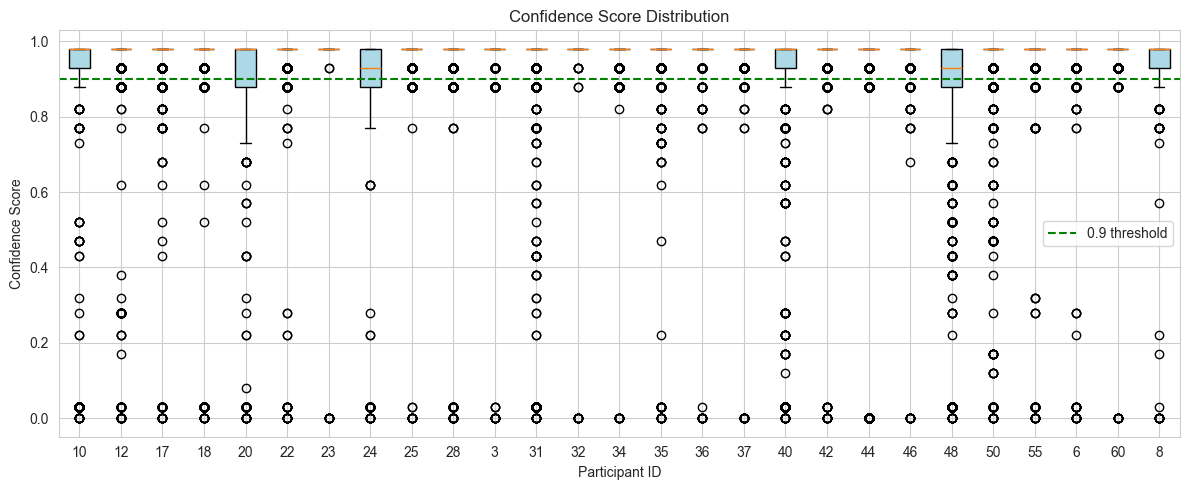

In [22]:
# Confidence distribution
fig, ax = plt.subplots(figsize=(12, 5))

conf_data = [pd.read_csv(f)['confidence'].values for f in csv_files]
ids = [int(f.stem) for f in csv_files]

bp = ax.boxplot(conf_data, tick_labels=ids, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

ax.axhline(y=0.9, color='green', linestyle='--', label='0.9 threshold')
ax.set_xlabel('Participant ID')
ax.set_ylabel('Confidence Score')
ax.set_title('Confidence Score Distribution')
ax.legend()
plt.tight_layout()
plt.show()

In [23]:
# Select participants from different score ranges
scores_df = pd.read_csv('../scoring/scores.csv')
video_ids = [int(f.stem) for f in csv_files]
scores_with_video = scores_df[scores_df['id'].isin(video_ids)].copy()

participant_ids = []

# Low SRS-2
low = scores_with_video[scores_with_video['srs2_score'] < 60]
if len(low) > 0:
    participant_ids.append(int(low.iloc[0]['id']))

# Medium SRS-2
med = scores_with_video[(scores_with_video['srs2_score'] >= 60) & (scores_with_video['srs2_score'] < 76)]
if len(med) > 0:
    participant_ids.append(int(med.iloc[0]['id']))

# High SRS-2
high = scores_with_video[(scores_with_video['srs2_score'] >= 76) & (scores_with_video['srs2_score'] < 90)]
if len(high) > 0:
    participant_ids.append(int(high.iloc[0]['id']))

# Very high SRS-2
vhigh = scores_with_video[scores_with_video['srs2_score'] >= 90]
if len(vhigh) > 0:
    participant_ids.append(int(vhigh.iloc[0]['id']))

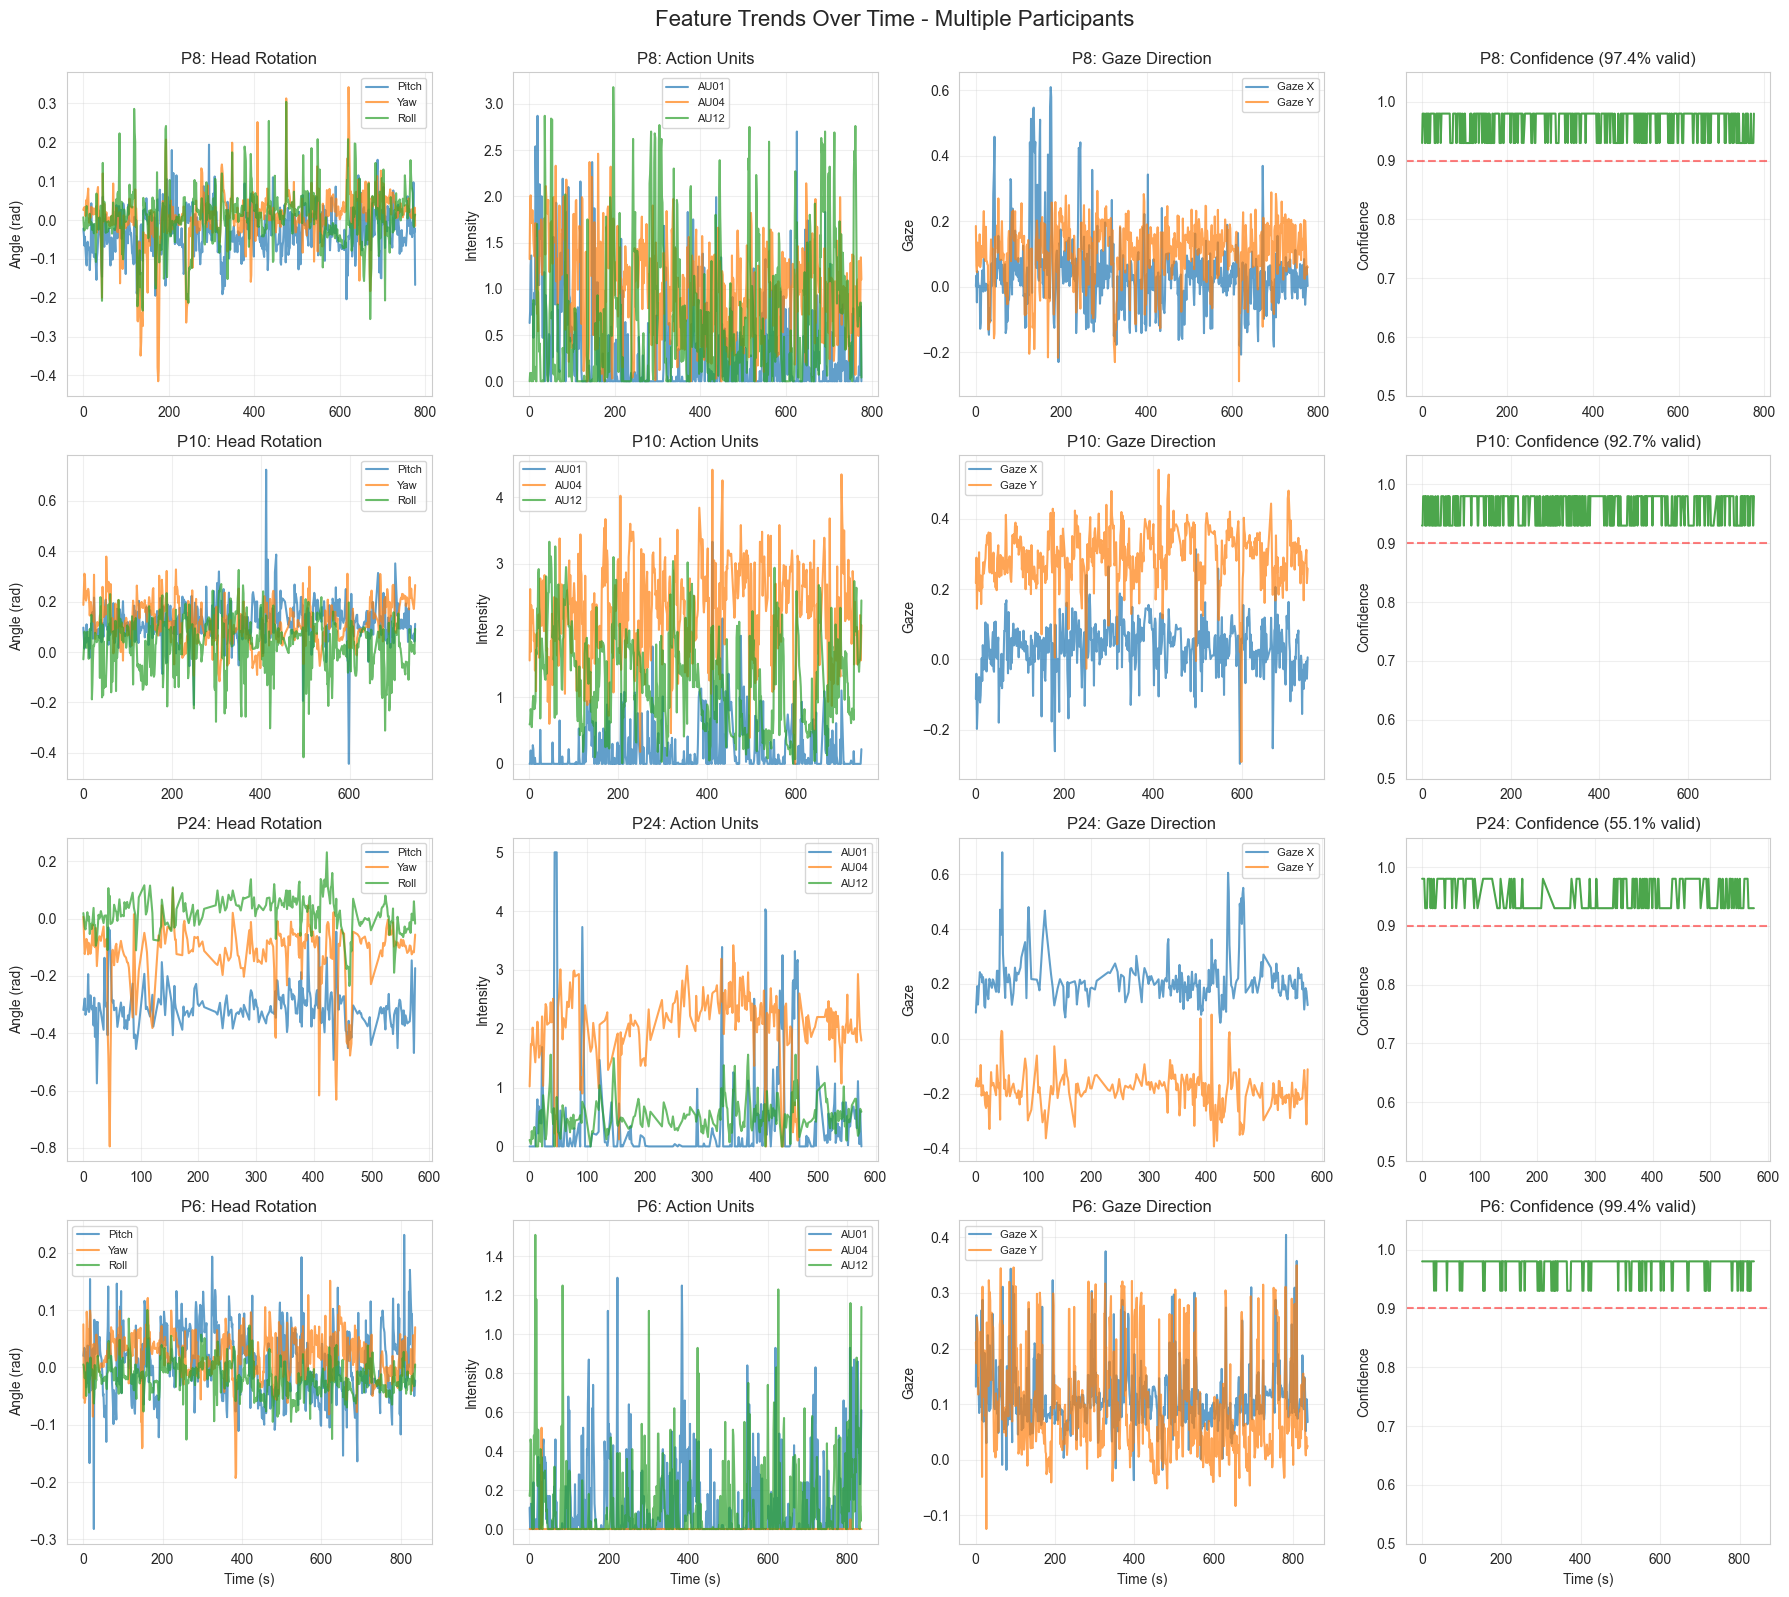

In [24]:
# Feature trends
fig, axes = plt.subplots(len(participant_ids), 4, figsize=(18, 4*len(participant_ids)))

if len(participant_ids) == 1:
    axes = axes.reshape(1, -1)

for idx, pid in enumerate(participant_ids):
    df = pd.read_csv(data_dir / f'{pid}.csv')
    df_valid = df[df['confidence'] > 0.9]
    df_sample = df_valid.iloc[::30]
    
    # Head rotation
    ax = axes[idx, 0]
    ax.plot(df_sample['timestamp'], df_sample['pose_Rx'], label='Pitch', alpha=0.7)
    ax.plot(df_sample['timestamp'], df_sample['pose_Ry'], label='Yaw', alpha=0.7)
    ax.plot(df_sample['timestamp'], df_sample['pose_Rz'], label='Roll', alpha=0.7)
    ax.set_ylabel('Angle (rad)')
    ax.set_title(f'P{pid}: Head Rotation')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    if idx == len(participant_ids) - 1:
        ax.set_xlabel('Time (s)')
    
    # Action units
    ax = axes[idx, 1]
    ax.plot(df_sample['timestamp'], df_sample['AU01_r'], label='AU01', alpha=0.7)
    ax.plot(df_sample['timestamp'], df_sample['AU04_r'], label='AU04', alpha=0.7)
    ax.plot(df_sample['timestamp'], df_sample['AU12_r'], label='AU12', alpha=0.7)
    ax.set_ylabel('Intensity')
    ax.set_title(f'P{pid}: Action Units')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    if idx == len(participant_ids) - 1:
        ax.set_xlabel('Time (s)')
    
    # Gaze
    ax = axes[idx, 2]
    ax.plot(df_sample['timestamp'], df_sample['gaze_0_x'], label='Gaze X', alpha=0.7)
    ax.plot(df_sample['timestamp'], df_sample['gaze_0_y'], label='Gaze Y', alpha=0.7)
    ax.set_ylabel('Gaze')
    ax.set_title(f'P{pid}: Gaze Direction')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    if idx == len(participant_ids) - 1:
        ax.set_xlabel('Time (s)')
    
    # Confidence
    ax = axes[idx, 3]
    ax.plot(df_sample['timestamp'], df_sample['confidence'], color='green', alpha=0.7)
    ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.5)
    ax.set_ylabel('Confidence')
    ax.set_title(f'P{pid}: Confidence ({len(df_valid)/len(df)*100:.1f}% valid)')
    ax.set_ylim([0.5, 1.05])
    ax.grid(True, alpha=0.3)
    if idx == len(participant_ids) - 1:
        ax.set_xlabel('Time (s)')

plt.suptitle('Feature Trends Over Time - Multiple Participants', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

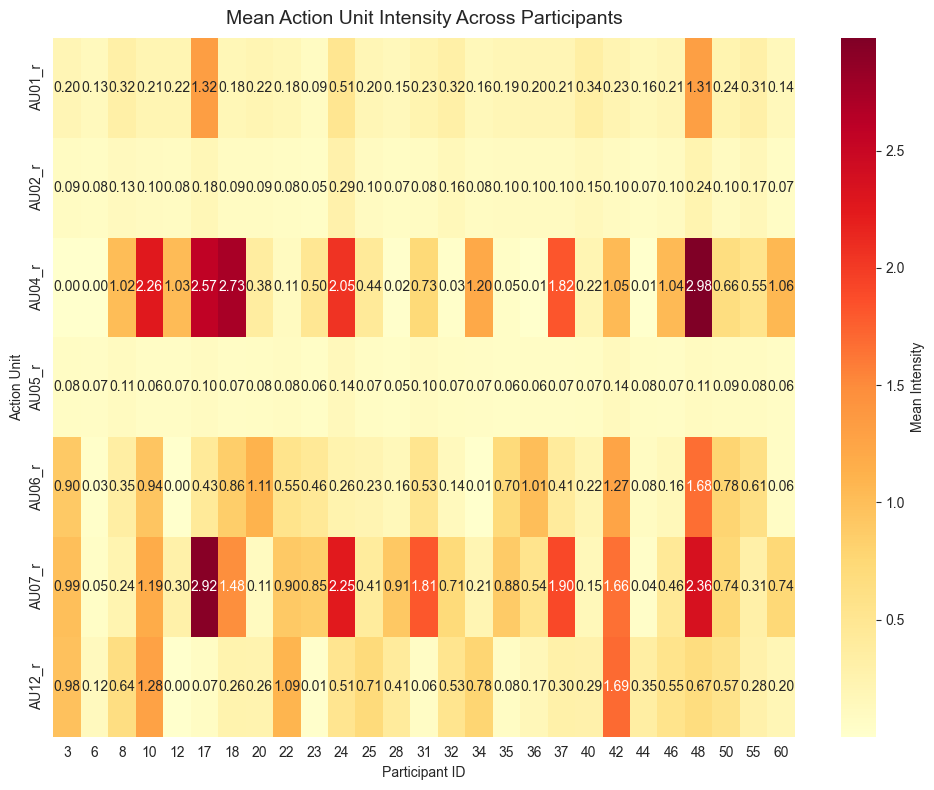

In [25]:
# Action unit intensity across participants
aus = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU12_r']
au_comparison = []

for f in csv_files:
    df = pd.read_csv(f)
    df_valid = df[df['confidence'] > 0.9]
    
    row = {'participant_id': int(f.stem)}
    for au in aus:
        row[au] = df_valid[au].mean()
    au_comparison.append(row)

au_df = pd.DataFrame(au_comparison).sort_values('participant_id')

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(au_df.set_index('participant_id')[aus].T, 
            annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Mean Intensity'},
            ax=ax)
ax.set_xlabel('Participant ID')
ax.set_ylabel('Action Unit')
ax.set_title('Mean Action Unit Intensity Across Participants', fontsize=14, pad=10)
plt.tight_layout()
plt.show()

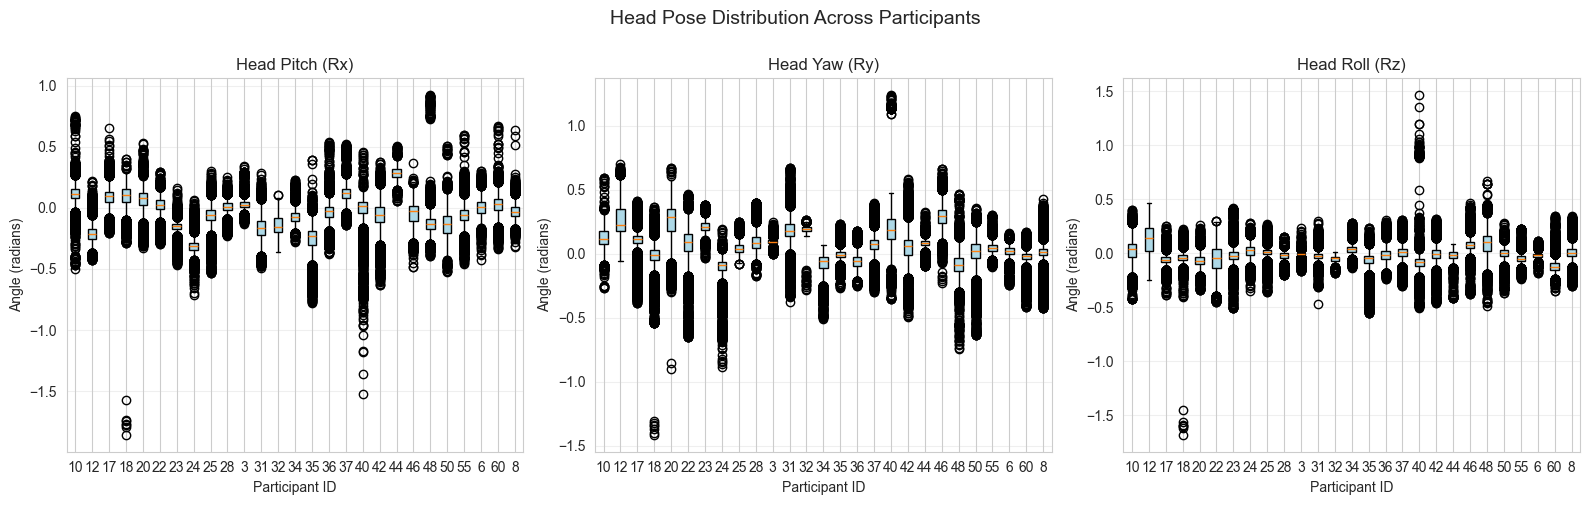

In [26]:
# Head pose comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
poses = ['pose_Rx', 'pose_Ry', 'pose_Rz']
titles = ['Head Pitch (Rx)', 'Head Yaw (Ry)', 'Head Roll (Rz)']

for idx, (pose, title) in enumerate(zip(poses, titles)):
    data = []
    for f in csv_files:
        df = pd.read_csv(f)
        df_valid = df[df['confidence'] > 0.9]
        data.append(df_valid[pose].values)
    
    bp = axes[idx].boxplot(data, tick_labels=[int(f.stem) for f in csv_files], patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    axes[idx].set_xlabel('Participant ID')
    axes[idx].set_ylabel('Angle (radians)')
    axes[idx].set_title(title)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Head Pose Distribution Across Participants', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

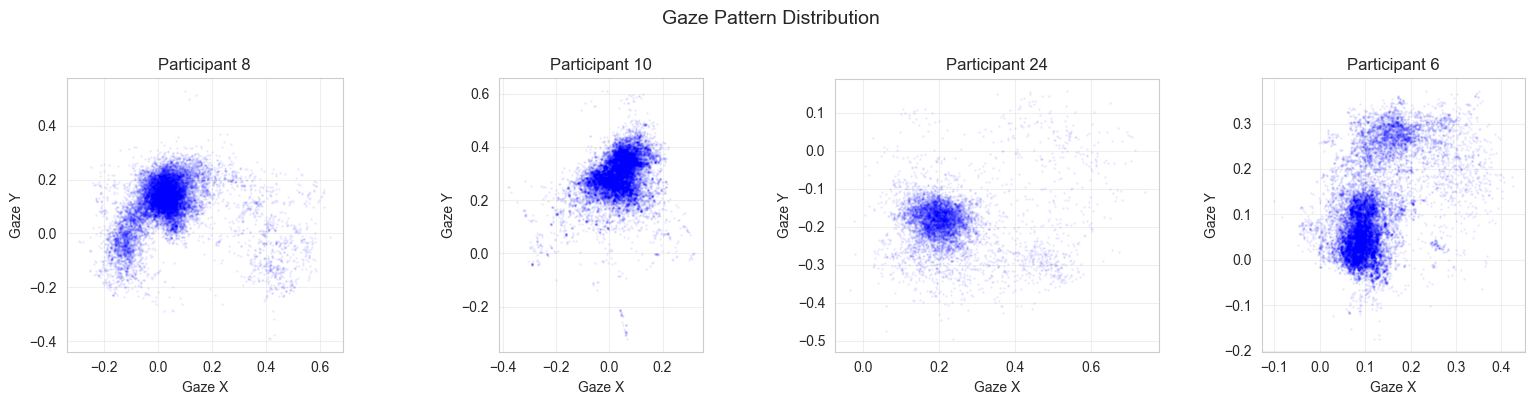

In [27]:
# Gaze pattern comparison
fig, axes = plt.subplots(1, len(participant_ids), figsize=(16, 4))

if len(participant_ids) == 1:
    axes = [axes]

for idx, pid in enumerate(participant_ids):
    df = pd.read_csv(data_dir / f'{pid}.csv')
    df_valid = df[df['confidence'] > 0.9]
    
    axes[idx].scatter(df_valid['gaze_0_x'], df_valid['gaze_0_y'], 
                     alpha=0.05, s=1, color='blue')
    axes[idx].set_xlabel('Gaze X')
    axes[idx].set_ylabel('Gaze Y')
    axes[idx].set_title(f'Participant {pid}')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_aspect('equal')

plt.suptitle('Gaze Pattern Distribution', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

In [28]:
summary_data = []
features = ['pose_Rx', 'pose_Ry', 'pose_Rz', 
            'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU12_r',
            'gaze_0_x', 'gaze_0_y']

for f in csv_files:
    df = pd.read_csv(f)
    df_valid = df[df['confidence'] > 0.9]
    
    row = {'participant_id': int(f.stem)}
    for feat in features:
        row[f'{feat}_mean'] = df_valid[feat].mean()
        row[f'{feat}_std'] = df_valid[feat].std()
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data).sort_values('participant_id')

mean_cols = ['participant_id'] + [f'{f}_mean' for f in features]
summary_df[mean_cols].round(3)

,participant_id,pose_Rx_mean,pose_Ry_mean,pose_Rz_mean,AU01_r_mean,AU02_r_mean,AU04_r_mean,AU05_r_mean,AU06_r_mean,AU07_r_mean,AU12_r_mean,gaze_0_x_mean,gaze_0_y_mean
10,3,0.035,0.096,-0.005,0.201,0.092,0.003,0.081,0.903,0.993,0.977,-0.017,0.224
24,6,0.006,0.021,-0.020,0.131,0.075,0.001,0.067,0.034,0.048,0.119,0.112,0.098
26,8,-0.027,0.010,0.004,0.325,0.128,1.021,0.107,0.353,0.241,0.644,0.033,0.113
0,10,0.116,0.124,0.027,0.210,0.101,2.260,0.064,0.939,1.186,1.278,0.033,0.292
1,12,-0.210,0.262,0.128,0.218,0.084,1.027,0.066,0.001,0.300,0.003,-0.194,-0.012
2,17,0.091,0.104,-0.062,1.324,0.181,2.575,0.105,0.434,2.923,0.071,0.043,0.154
3,18,0.097,-0.017,-0.041,0.178,0.093,2.729,0.069,0.856,1.475,0.259,0.110,0.108
4,20,0.064,0.262,-0.066,0.217,0.087,0.377,0.077,1.114,0.107,0.256,-0.074,0.146
5,22,0.022,0.075,-0.053,0.177,0.080,0.111,0.084,0.552,0.901,1.091,0.061,0.132
6,23,-0.154,0.214,-0.017,0.091,0.052,0.499,0.058,0.465,0.853,0.012,-0.073,-0.058
